# Time series analysis on the data International Airline passengers form 1940 to 1960

In [4]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose



In [6]:
# data fetch from github
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.head()


,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


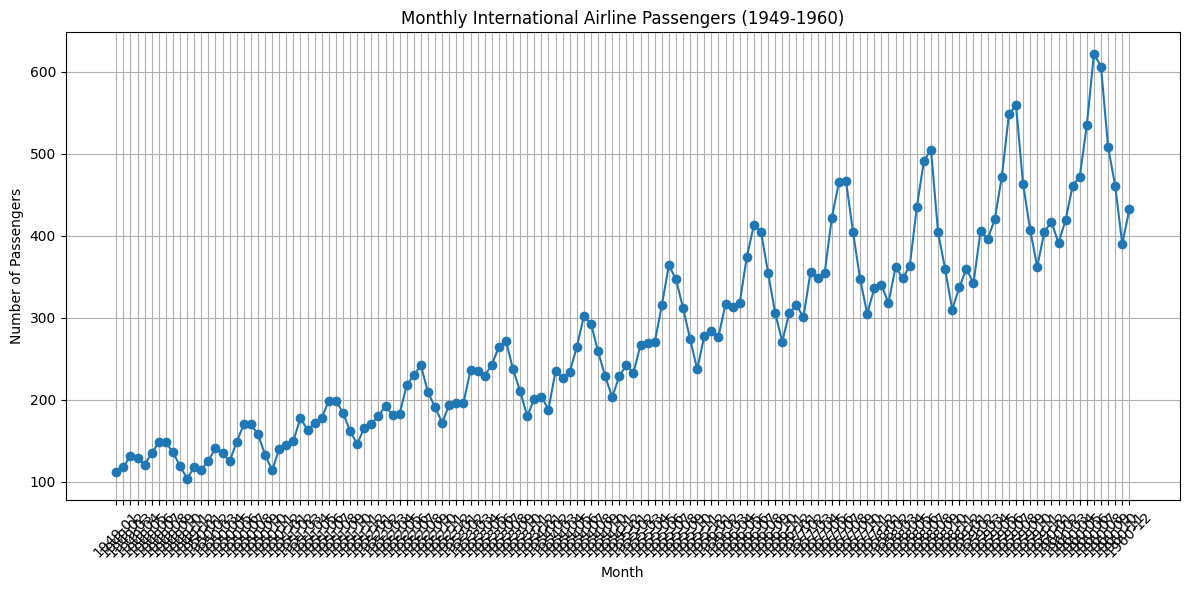

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df['Month'], df['Passengers'], marker='o', linestyle='-')
plt.title('Monthly International Airline Passengers (1949-1960)')
plt.xlabel('Month')
plt.ylabel('Number of Passengers')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


In [8]:
df.shape

(144, 2)

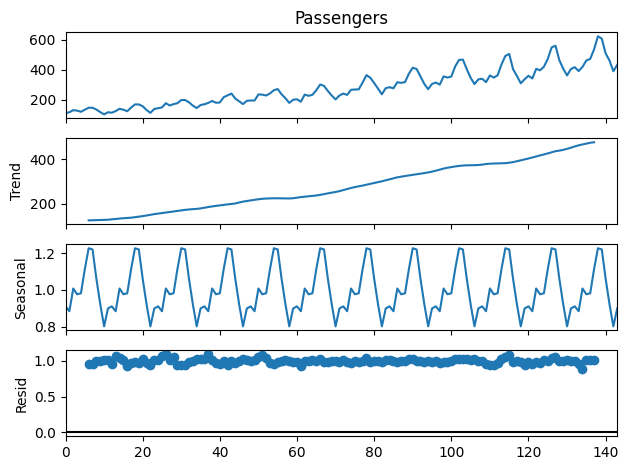

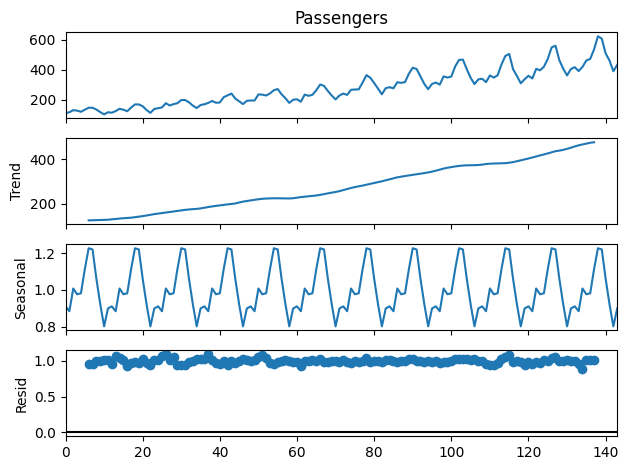

In [11]:
# decompose the data into trend, seasonal and residual
decompose = seasonal_decompose(df["Passengers"], model='multiplicative', period=12)
decompose.plot()

Basic Statistics:
count    144.000000
mean     280.298611
std      119.966317
min      104.000000
25%      180.000000
50%      265.500000
75%      360.500000
max      622.000000
Name: Passengers, dtype: float64


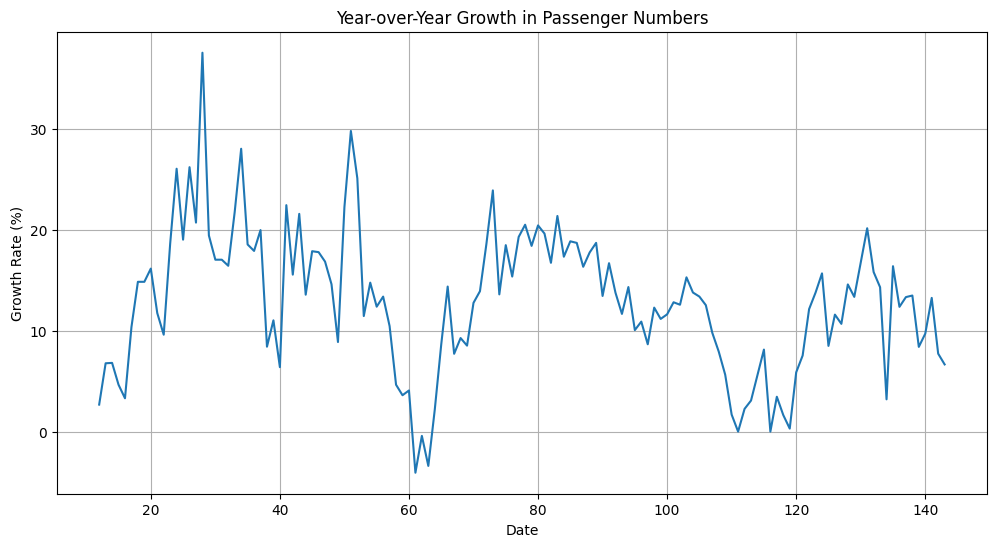

In [12]:
# Basic statistics
print("Basic Statistics:")
print(df['Passengers'].describe())

# Calculate year-over-year growth
df['YoY_Growth'] = df['Passengers'].pct_change(periods=12) * 100
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['YoY_Growth'])
plt.title('Year-over-Year Growth in Passenger Numbers')
plt.xlabel('Date')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.show()

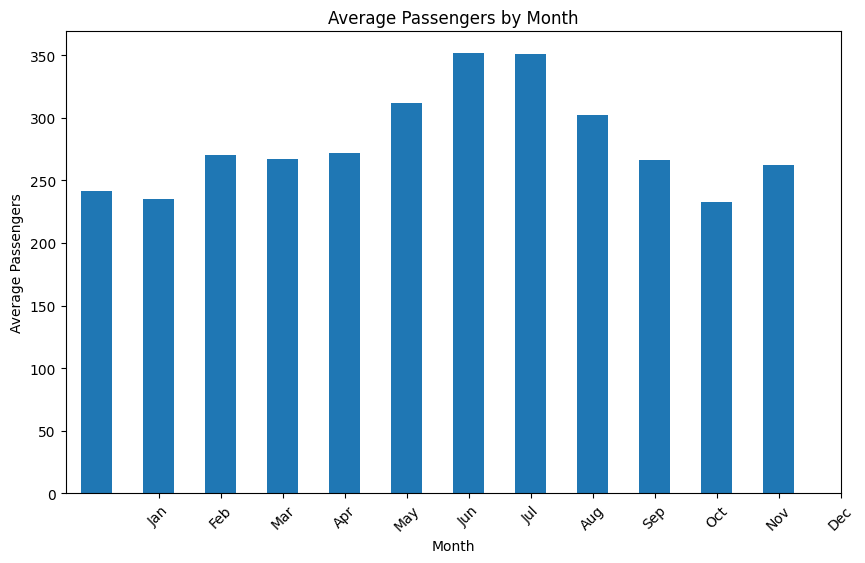

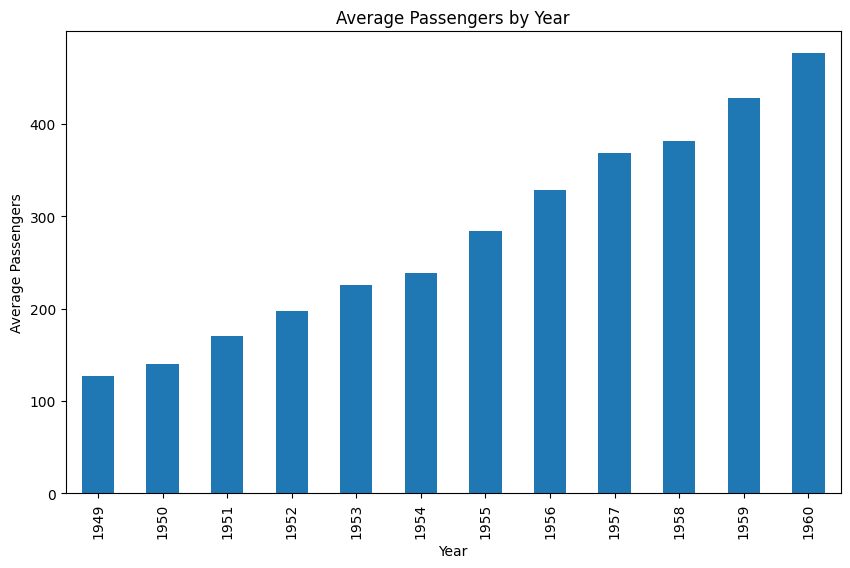

In [14]:
# Monthly averages to see seasonality
df['Month'] = pd.to_datetime(df['Month']).dt.to_period('M')  # Ensure 'Month' is in datetime format
monthly_avg = df.groupby(df['Month'].dt.month)['Passengers'].mean()
plt.figure(figsize=(10, 6))
monthly_avg.plot(kind='bar')
plt.title('Average Passengers by Month')
plt.xlabel('Month')
plt.ylabel('Average Passengers')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

# Yearly averages to see trend
yearly_avg = df.groupby(df['Month'].dt.year)['Passengers'].mean()
plt.figure(figsize=(10, 6))
yearly_avg.plot(kind='bar')
plt.title('Average Passengers by Year')
plt.xlabel('Year')
plt.ylabel('Average Passengers')
plt.show()

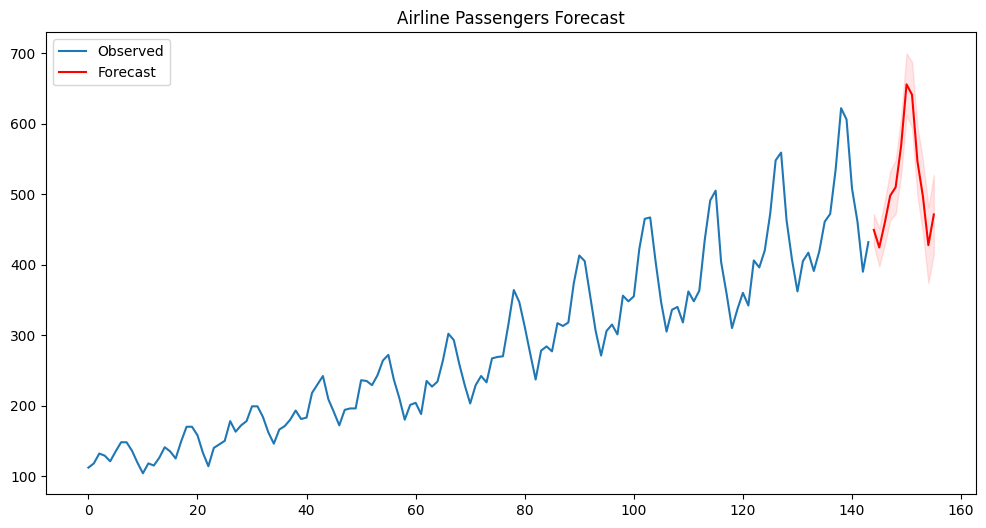

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model
model = SARIMAX(df['Passengers'], 
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12))
results = model.fit()

# Make predictions
forecast = results.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Passengers'], label='Observed')
plt.plot(forecast_mean.index, forecast_mean, color='r', label='Forecast')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='r', alpha=.1)
plt.title('Airline Passengers Forecast')
plt.legend()
plt.show()

In [16]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
result = adfuller(df['Passengers'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.8153688792060441
p-value: 0.9918802434376409
Critical values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


Model Accuracy Metrics:
Mean Absolute Error (MAE): 10.04 passengers
Root Mean Square Error (RMSE): 15.56 passengers
R-squared (R²): 0.983


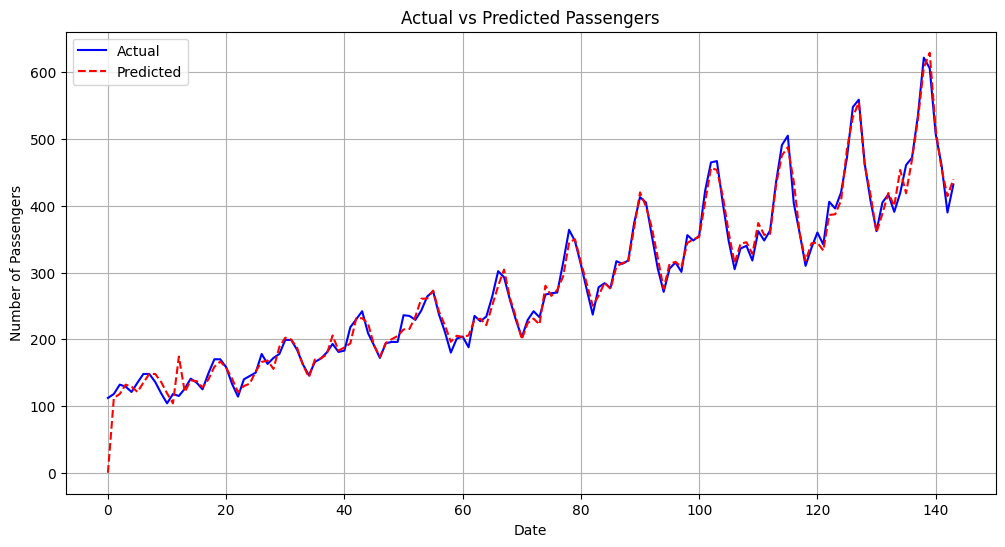


Mean Absolute Percentage Error (MAPE): 4.57%


In [17]:
# Calculate model performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Get the model's in-sample predictions
predictions = results.get_prediction(start=df.index[0])
pred_mean = predictions.predicted_mean

# Calculate metrics
mae = mean_absolute_error(df['Passengers'], pred_mean)
rmse = np.sqrt(mean_squared_error(df['Passengers'], pred_mean))
r2 = r2_score(df['Passengers'], pred_mean)

print(f'Model Accuracy Metrics:')
print(f'Mean Absolute Error (MAE): {mae:.2f} passengers')
print(f'Root Mean Square Error (RMSE): {rmse:.2f} passengers')
print(f'R-squared (R²): {r2:.3f}')

# Visualize actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Passengers'], label='Actual', color='blue')
plt.plot(df.index, pred_mean, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Passengers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()

# Calculate percentage error
mape = np.mean(np.abs((df['Passengers'] - pred_mean) / df['Passengers'])) * 100
print(f'\nMean Absolute Percentage Error (MAPE): {mape:.2f}%')

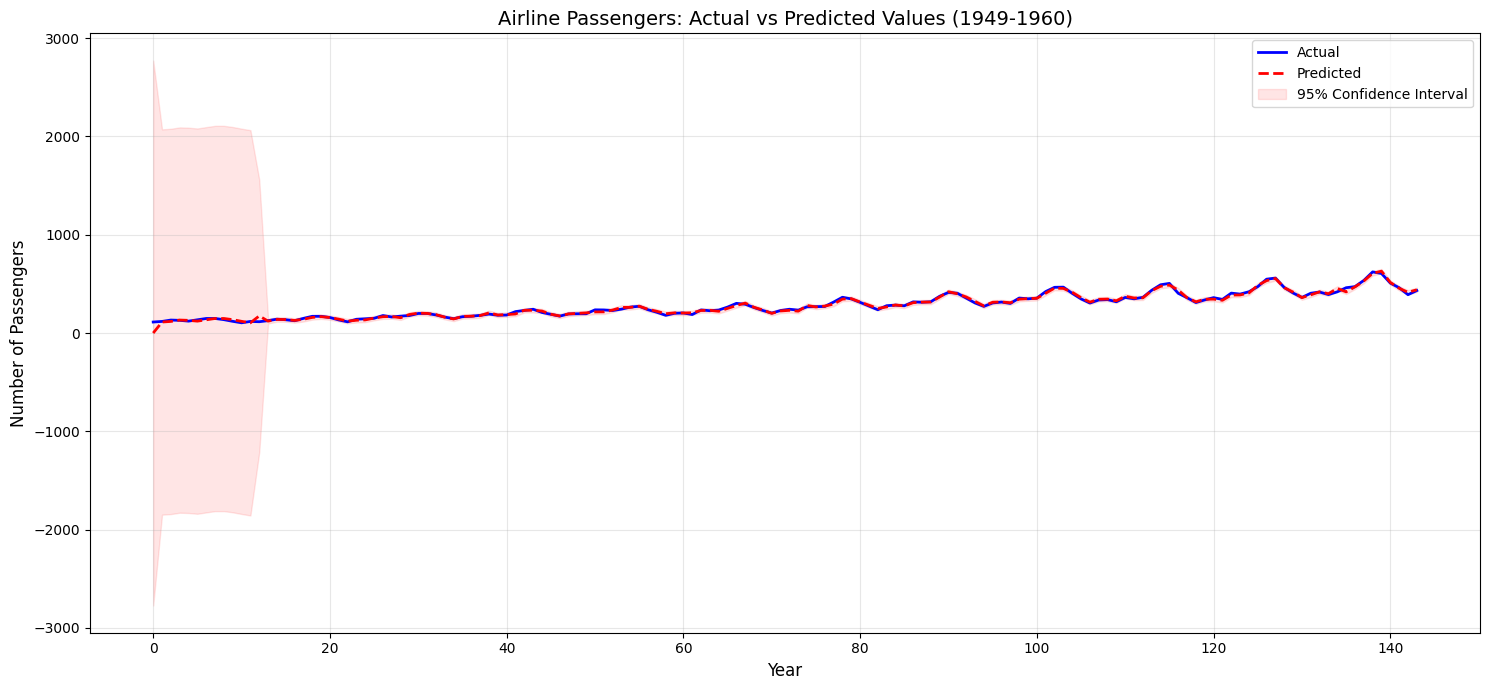

In [18]:
# Plot actual vs predicted with confidence intervals
plt.figure(figsize=(15, 7))

# Plot actual values
plt.plot(df.index, df['Passengers'], label='Actual', color='blue', linewidth=2)

# Plot predicted values
plt.plot(df.index, pred_mean, label='Predicted', color='red', linestyle='--', linewidth=2)

# Get and plot confidence intervals
predictions = results.get_prediction(start=df.index[0])
pred_conf = predictions.conf_int()
plt.fill_between(df.index, 
                 pred_conf.iloc[:, 0], 
                 pred_conf.iloc[:, 1], 
                 color='red', 
                 alpha=0.1, 
                 label='95% Confidence Interval')

plt.title('Airline Passengers: Actual vs Predicted Values (1949-1960)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()